## Import Packages

In [407]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle
# from numpy.linalg import inv as inv

#Import function to get the covariate matrix that includes spike history from previous bins
from preprocessing_funcs import get_spikes_with_history

#Import decoder functions
import Decoder_funcs
from Decoder_funcs import get_vaf

## Import Data

**Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin**

**The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"**

In [591]:
# folder='/Users/jig289/Dropbox/MATLAB/Projects/In_Progress/BMI/Processed_Data/'
folder='/home/jglaser2/Data/DecData/'

with open(folder+'hc_test_data.pickle','rb') as f:
    neural_data,pos_binned=pickle.load(f)

## Define Covariates ##

### User Options: Define what time period to use spikes from

In [592]:
#This is relevant for all decoders except the Kalman filter (KF)

bins_current=1 #Whether to use concurrent time bin of neural data
bins_before=5 #How many bins of neural data prior to the output are used for decoding
bins_after=4 #How many bins of neural data after (and including) the output are used for decoding
bins_surrounding=bins_before+bins_before+bins_after


# Below is only relevant for the KF

lag=2 #What time bin of spikes should be used relative to the output
#(lag=-1 means use the spikes 1 bin before the output)

### Get Input Covariates

In [593]:
#Remove neurons with too few spikes
nd_sum=np.nansum(neural_data,axis=0)
rmv_nrn=np.where(nd_sum<100)
neural_data=np.delete(neural_data,rmv_nrn,1)

#Function to get the covariate matrix that includes spike history from previous bins
#This puts the spikes in the format for the RNN
X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

#Put in "flat" format for XGB and linear decoders
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

#Format for Kalman filter
X_kf=neural_data


In [594]:
X_kf.shape

(28039, 46)

### Get Output Covariates

In [595]:
#Set decoding output for all decoders except the KF
y=pos_binned


#Set decoding output for the KF
# pos=np.zeros(vels_binned.shape)
# pos[0,:]=0
# for i in range(pos.shape[0]-1):
#     pos[i+1,0]=pos[i,0]+vels_binned[i,0]*.05
#     pos[i+1,1]=pos[i,1]+vels_binned[i,1]*.05
    
temp=np.diff(pos_binned,axis=0)
vels=np.concatenate((temp,temp[-1:,:]),axis=0)

temp2=np.diff(vels,axis=0)
acc=np.concatenate((temp2,temp2[-1:,:]),axis=0)

# y_kf=np.concatenate((pos,vels_binned,acc),axis=1)

# y_kf=np.concatenate((pos_binned,vels),axis=1)
y_kf=np.concatenate((pos_binned,vels,acc),axis=1)
# y_kf=pos_binned

### Process Covariates

In [596]:
def zscore_nan(X,axis):
    X_zscore=(X - np.nanmean(X,axis=axis)) / np.nanstd(X,axis=axis)
    return X_zscore

In [597]:
#Normalize inputs
X=zscore_nan(X,axis=0)
X_flat=zscore_nan(X_flat,axis=0)
X_kf=zscore_nan(X_kf,axis=0)

#Zero-center outputs
y_mean=np.nanmean(y,axis=0)
y=y-y_mean

y_kf_mean=np.nanmean(y_kf,axis=0)
y_kf=y_kf-y_kf_mean

In [598]:
#Remove time bins with no output (y value)
rmv_time=np.where(np.isnan(y[:,0]) | np.isnan(y[:,1]))
X=np.delete(X,rmv_time,0)
X_flat=np.delete(X_flat,rmv_time,0)
X_kf=np.delete(X_kf,rmv_time,0)
y=np.delete(y,rmv_time,0)
y_kf=np.delete(y_kf,rmv_time,0)

In [599]:
#More Kalman filter preprocessing
num_examples=X.shape[0]

#Re-align data to take lag into account
if lag<0:
    y_kf=y_kf[-lag:,:]
    X_kf=X_kf[0:num_examples+lag,:]
if lag>0:
    y_kf=y_kf[0:num_examples-lag,:]
    X_kf=X_kf[lag:num_examples,:]

## Split into training/testing/validation sets

### User Options

In [600]:
#Set what part of data should be part of the training/testing/validation sets
training_range=[0, 0.6]
testing_range=[0.6, 0.6]
valid_range=[0.6,0.7]

### Split Data: For all decoders except KF

In [601]:
num_examples=X.shape[0]

#Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
#This makes it so that the different sets don't include overlapping neural data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples))+bins_before,np.int(np.round(testing_range[1]*num_examples))-bins_after)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples))+bins_before,np.int(np.round(valid_range[1]*num_examples))-bins_after)

#Get training data
X_train=X[training_set,:,:]
X_flat_train=X_flat[training_set,:]
y_train=y[training_set,:]

#Get testing data
X_test=X[testing_set,:,:]
X_flat_test=X_flat[testing_set,:]
y_test=y[testing_set,:]

#Get validation data
X_valid=X[valid_set,:,:]
X_flat_valid=X_flat[valid_set,:]
y_valid=y[valid_set,:]

### Split Data: For KF

In [602]:
#Number of examples after taking into account bins removed for lag alignment
num_examples_kf=X_kf.shape[0]
        
#Note that each range has a buffer of 1 bin at the beginning and end
#This makes it so that the different sets don't include overlapping data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples_kf))+1,np.int(np.round(training_range[1]*num_examples_kf))-1)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples_kf))+1,np.int(np.round(testing_range[1]*num_examples_kf))-1)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples_kf))+1,np.int(np.round(valid_range[1]*num_examples_kf))-1)

#Get training data
X_kf_train=X_kf[training_set,:]
y_kf_train=y_kf[training_set,:]

#Get testing data
X_kf_test=X_kf[testing_set,:]
y_kf_test=y_kf[testing_set,:]

#Get validation data
X_kf_valid=X_kf[valid_set,:]
y_kf_valid=y_kf[valid_set,:]

## Run Decoders

### Wiener Filter (Linear Regression)

In [451]:
#Fit model
model_regr=Decoder_funcs.lin_reg_model(X_flat_train,y_train)
#Get predictions
y_valid_pred_lin=model_regr.predict(X_flat_valid)
#Get metric of fit
vafs_lin=get_vaf(y_valid,y_valid_pred_lin)
print('VAFS:', vafs_lin)

('VAFS:', [0.33904088250820319, 0.34173142207881602])


### Wiener Cascade (Linear Nonlinear Model)

In [452]:
#Fit model
models_wc=Decoder_funcs.wiener_casc_model(X_flat_train,y_train,deg=3)
#Get predictions
y_valid_pred_wc=Decoder_funcs.wiener_casc_predict(models_wc,X_flat_valid)
#Get metric of fit
vafs_wc=get_vaf(y_valid,y_valid_pred_wc)
print('VAFS:', vafs_wc)

('VAFS:', [0.34104933842790874, 0.37617052818545949])


### XGBoost (Extreme Gradient Boosting)

In [609]:
#Fit model
model_xgb=Decoder_funcs.xgb_model(X_flat_train,y_train,max_depth=5,num_round=200)
#Get predictions
y_valid_pred_xgb=Decoder_funcs.xgb_predict(model_xgb,X_flat_valid)
#Get metric of fit
vafs_xgb=get_vaf(y_valid,y_valid_pred_xgb)
print('VAFS:', vafs_xgb)

('VAFS:', [0.42997646291942193, 0.56835274280851822])


In [ ]:
100/2/200 (num trees): 0.39266568940432889, 0.51810806070760884
100/3/200: 0.41524206398930863, 0.54666499991477924
100/4/200: 0.42997646291942193, 0.56835274280851822
100/5/200:

### Simple RNN

In [453]:
#Fit model
model_rnn=Decoder_funcs.SimpleRNN_model(X_train,y_train,units=400,dropout=0,num_epochs=10)
#Get predictions
y_valid_pred_rnn=model_rnn.predict(X_valid)
#Get metric of fit
vafs_rnn=get_vaf(y_valid,y_valid_pred_rnn)
print('VAFS:', vafs_rnn)

('VAFS:', [0.32586083263374854, 0.64028022607260948])


In [ ]:
0: 0.26168603141623714, 0.61854281716834081
100: 0.37987804206579556, 0.66468623776699176 ***
100: 0.39526474322017857, 0.61718822179220623
200: 0.34247166072249746, 0.64953051105159387
200: 0.32586083263374854, 0.64028022607260948
    
100 (do=.25): 0.41051970272221128, 0.49155441644353559    
200 (do=.25): 0.37328858313846436, 0.47738201781604672

### GRU (Gated Recurrent Unit)

In [605]:
#Fit model
model_gru=Decoder_funcs.GRU_model(X_train,y_train,units=400,dropout=.25,num_epochs=10)
#Get predictions
y_valid_pred_gru=model_gru.predict(X_valid)
#Get metric of fit
vafs_gru=get_vaf(y_valid,y_valid_pred_gru)
print('VAFS:', vafs_gru)

('VAFS:', [0.51415263242316989, 0.65394297955580427])


In [ ]:
100: 0.54546697656294374, 0.54841515198991608
200: 0.36810617108987109, 0.65220844985986037

100 (do=0.25): 0.51616956481563814, 0.69349543924728019   ***
200 (do=0.25): 0.51739828778077679, 0.65663416510588712
    
100 (do=0.5): 0.51415263242316989, 0.65394297955580427

### LSTM (Long Short Term Memory)

In [606]:
#Fit model
model_lstm=Decoder_funcs.LSTM_model(X_train,y_train,units=400,dropout=.25,num_epochs=10)
#Get predictions
y_valid_pred_lstm=model_lstm.predict(X_valid)
#Get metric of fit
vafs_lstm=get_vaf(y_valid,y_valid_pred_lstm)
print('VAFS:', vafs_lstm)

('VAFS:', [0.50339672750134601, 0.5859139636607491])


In [ ]:
100: 0.49317336618709273, 0.61845889921688046
200: 0.45256298993038568, 0.60661911226181298
    
100 (do=.25): 0.56385154546752791, 0.68324092485799803 ***
200 (do=.25): 0.54235771983784709, 0.73835052753708785

100 (do=.5): 0.50339672750134601, 0.5859139636607491

### Kalman Filter

In [587]:
#Fit model
model_kf=Decoder_funcs.kf_model(X_kf_train,y_kf_train)
#Get predictions
y_valid_pred_kf=Decoder_funcs.kf_predict(model_kf,X_kf_valid,y_kf_valid)
#Get metric of fit
vafs_kf=get_vaf(y_kf_valid,y_valid_pred_kf)
print('VAFS:',vafs_kf)

('VAFS:', [0.16691535860787543, 0.37053198857547931, 0.029756292296734821, 0.034785666236592294, -0.031180091214654482, -0.015971939850210726])


In [ ]:
-2: [0.097611884601205512, 0.36547889285840796]
-1: [0.095393462491166647, 0.37389251739337515]
0: [0.091630740440466041, 0.3791849117112982]
1: [0.079065572143858343, 0.38292777207290718]
2: [0.06880046608314061, 0.38690388751766169]
3: [0.059033184155031226, 0.38787177865862721]
    
w/ vel    
-2: [0.17190210511431603, 0.32729138922298451]
-1: [0.12905505556735375, 0.29137645776851717]
0: [0.090696123055508893, 0.34316480803581018]
1: [0.13697548369859724, 0.3627382168470652]
2: [0.12496161059863686, 0.33768351555839315]
3: [0.088148536311941306, 0.35644925268529937]
    
200 min:
    
0: [0.11805069313519079, 0.4494411992557078]    
1: [0.10539192689517296, 0.45495736846473522] 
    
w/vel
-1: [0.14484639881421724, 0.39879457547194275]
0: [0.1326480035956743, 0.41261364711370641]
1: [0.15190057053707606, 0.41873086969516216] 
    
w/ acc:
-1: [0.18754986072897728, 0.41968920248369224]
0: [0.16798101300161439, 0.42365927445512142]
1: [0.17006979887904272, 0.43258133045239522] 
2: [0.17739853733033761, 0.43560952774231243]

## Make Plots

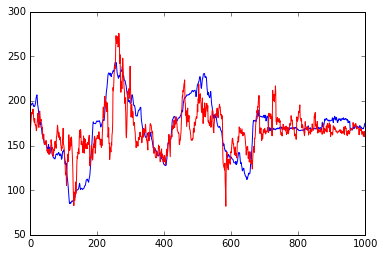

In [588]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_lin=plt.figure()
plt.plot(y_valid[1000:2000,0]+y_mean[0],'b')
plt.plot(y_valid_pred_lin[1000:2000,0]+y_mean[0],'r')
#Save figure
# fig_x_lin.savefig('x_velocity_decoding.eps')